# Fig. 3. Connectivity mapping of the left dorsolateral prefrontal cortex cluster.

In [1]:
# set_env.py is not included in the repo
# it defines $HCP_DENSE_PATH, $PROJECT_DIR (required) and $HCP_DIR (optional)
# in environment variables
import set_env

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import neuromaps.transforms
import nibabel
import nilearn.image
import nilearn.surface
import surfplot
import pyvirtualdisplay

# create virtual display for plotting meshes in remote servers
disp=pyvirtualdisplay.Display(visible=False)
disp.start()



sys.path.append('../scripts')
from helpers import io, transform, plot

plt.rcParams.update({"font.size": 12, "font.family": "Asana Math", "figure.dpi": 192})

# A. Meta-analytical connectivity mapping

### Run MACM

MACM of L DLPFC cluster found in Treated > Untreated contrast is performed using pyALE within `../macm/run.py`. This script first creates a dataset of experiments in BrainMap which have reported at least one activation in the cluster, and then runs an ALE meta-analysis on the dataset. The script is run as a HTCondor job through `condor_submit run.submit` which submits a HTCondor job that executes `run.sh` which itself is a wrapper for `run.py`.

In [20]:
!condor_submit ../results/macm/run.submit

Submitting job(s).
1 job(s) submitted to cluster 3708611.


After it's done:

In [22]:
!cp ../logs/3708611.0.out ../results/macm/Contrast_increased_cFWE05/macm_results_summary.txt

In [23]:
!cat ../results/macm/Contrast_increased_cFWE05/macm_results_summary.txt

/data/group/cng/Projects/Amin/antidepressants_ale/scripts/macm/../../results/macm analysis.xlsx coordinates.xlsx
enter main
MACM : 54 experiments; average of 15.41 subjects per experiment
MACM - illustrate Foci
MACM - computing ALE and null PDF
MACM - computing p-values & TFCE
MACM - simulating null
MACM - inference and printing
Min p-value for FWE:0.0
Min p-value for cFWE:0.0
Min p-value for TFCE:0.0
MACM - done!


### Plot

/data/group/cng/Projects/Amin/antidepressants_ale/venv/lib/python3.11/site-packages/nilearn/image/image.py:1066: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


color range: 3.0931165 8.125891


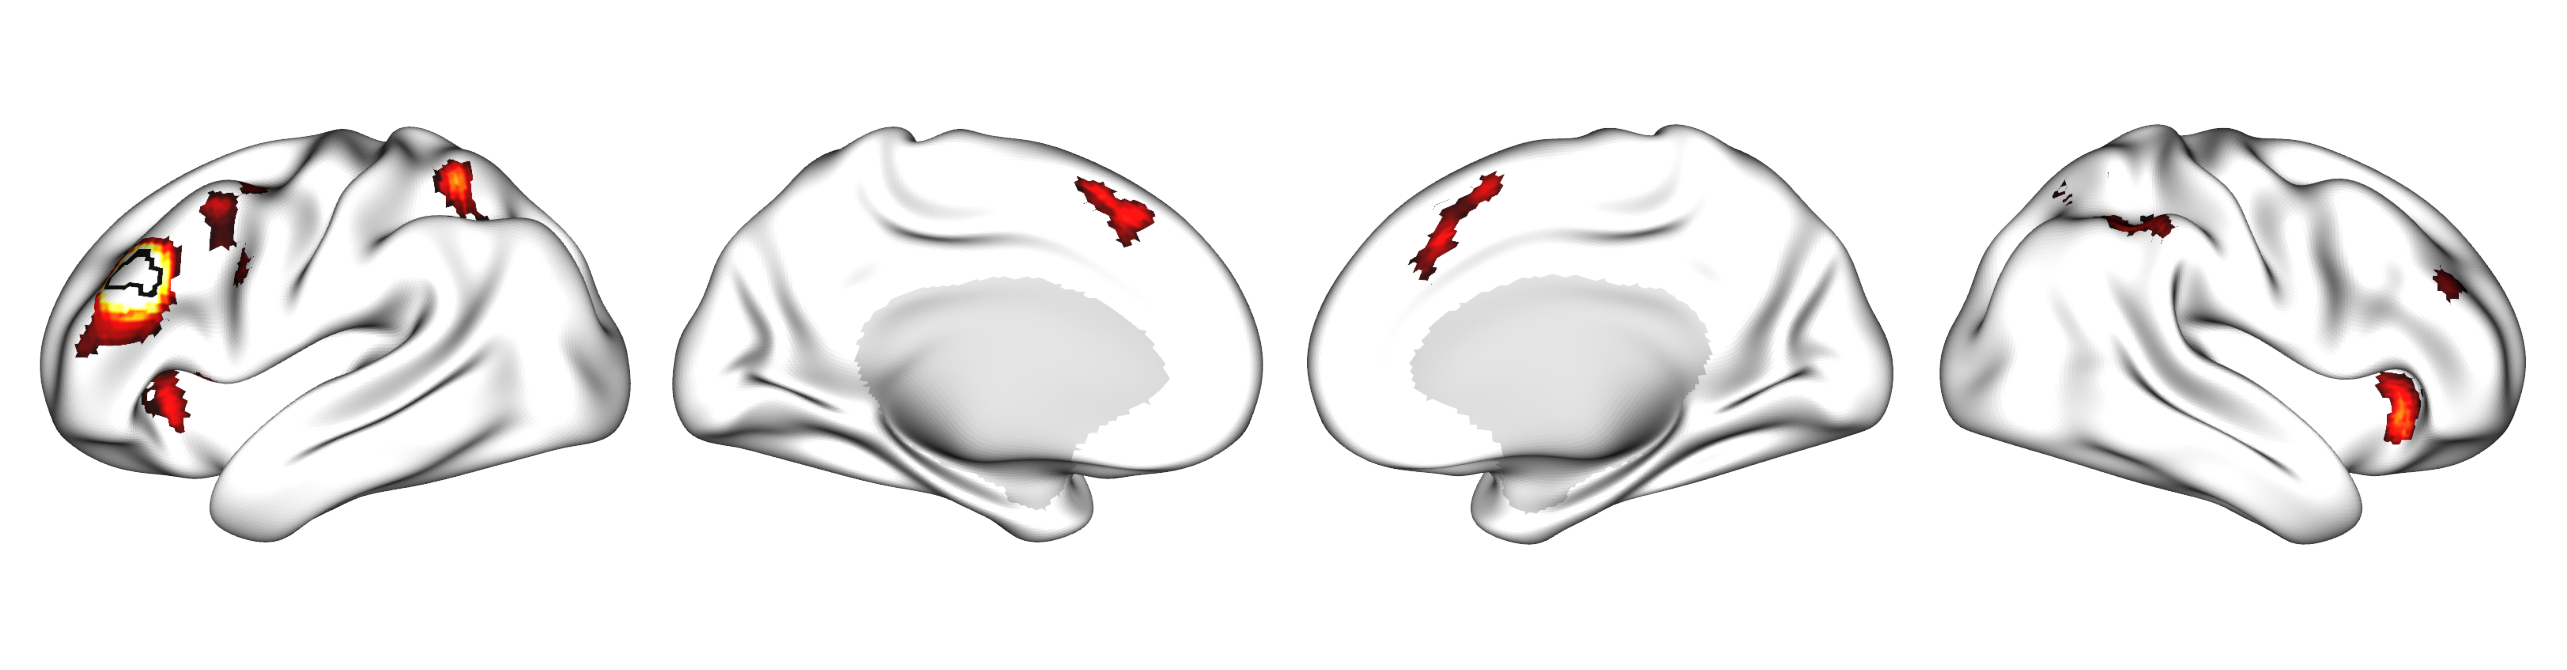

In [5]:
macm_sig = nilearn.image.binarize_img(
    os.path.join(
        io.RESULTS_DIR, 'macm', 'Contrast_increased_cFWE05',
        'Results', 'MainEffect', 'Full', 'Volumes',
        'Corrected', 'MACM_cFWE05.nii'
    ),
)
macm_unthresh = nibabel.load(os.path.join(
    io.RESULTS_DIR, 'macm', 'Contrast_increased_cFWE05',
    'Results', 'MainEffect', 'Full', 'Volumes',
    'Z', 'MACM.nii'
))
# transform to fsLR
macm_sig_fslr = neuromaps.transforms.mni152_to_fslr(macm_sig, method='nearest')
macm_sig_fslr = np.concatenate([macm_sig_fslr[0].agg_data(), macm_sig_fslr[1].agg_data()])
macm_sig_fslr = macm_sig_fslr > 0
# transform macm unthresholded to fsLR and mask it with macm_sig_fslr
macm_unthresh_fslr = neuromaps.transforms.mni152_to_fslr(macm_unthresh, method='nearest')
macm_unthresh_fslr = np.concatenate([macm_unthresh_fslr[0].agg_data(), macm_unthresh_fslr[1].agg_data()])
macm_thresh_fslr = macm_unthresh_fslr.copy()
macm_thresh_fslr[~macm_sig_fslr] = np.NaN
# remove midline
macm_thresh_fslr[~transform.FSLR_CORTEX] = np.NaN

# create cluster mask
cluster_nifti = os.path.join(io.RESULTS_DIR, 'ale', 'Contrast', 
                             'Results', 'MainEffect', 'Full', 'Volumes', 'Corrected',
                             'Contrast_increased_cFWE05.nii')
cluster_fslr = neuromaps.transforms.mni152_to_fslr(cluster_nifti, method='nearest')
cluster_fslr = np.concatenate([cluster_fslr[0].agg_data(), cluster_fslr[1].agg_data()])
cluster_mask_fslr = cluster_fslr > 0

# plot
vmin = np.nanmin(macm_thresh_fslr)
vmax = np.nanmax(macm_thresh_fslr)
print("color range:", vmin, vmax)
p = surfplot.Plot(surf_lh=plot.MESHES_FSLR['L'], surf_rh=plot.MESHES_FSLR['R'], 
                 layout='row', size = (1600, 400), zoom = 1.2, brightness=1, mirror_views=True,
                 )
p.add_layer(macm_thresh_fslr, cmap='hot', cbar=False, color_range=(vmin,vmax))
p.add_layer(cluster_mask_fslr, cmap='Greys', as_outline=True, cbar=False)
p.add_layer(~transform.FSLR_CORTEX, cmap='Greys_r', cbar=False, color_range=(0, 1.5))
p.build();

/data/group/cng/Projects/Amin/antidepressants_ale/public/scripts/figures/../helpers/plot.py:172: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Right Hippocampus' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tian_to_mesh.loc[label] = f'{hem} {abbr_to_full[key]}'
/data/group/cng/Projects/Amin/antidepressants_ale/venv/lib/python3.11/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


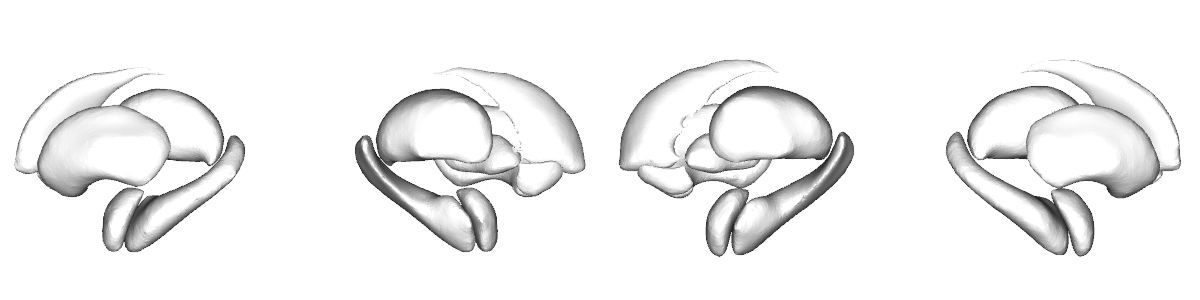

In [6]:
macm_parc = transform.parcellate_volumetric(macm_sig) + 1e-5 
# + 1e-5 so that the subcortical structures are shown 
# otherwise it will be an empty plot since no significant clusters
# exist in subcortex and all are 0
plot.plot_parc_subcortical(macm_parc, color_range=(vmin, vmax), cmap='Greys')

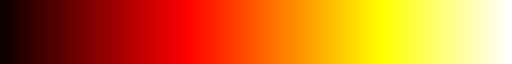

In [7]:
sns.color_palette('hot', as_cmap=True)

## B. Resting-state functional connectivity

Calculate average FC of the cluster using HCP dense connectome:

In [7]:
# transform cluster extent from fsLR to Cifti
# and identify grayordinates within the cluster
cluster_mask_cifti = transform.fsLR_to_cifti(cluster_mask_fslr.astype('int')).squeeze() > 0
cluster_mask_cifti_points = np.where(cluster_mask_cifti)[0]
print(f"{len(cluster_mask_cifti_points)} grayordinates within the cluster")
# load dense connectome and store the 
# connectivity of cluster grayordinates
dconn = nibabel.load(os.environ['HCP_DENSE_PATH'])
cluster_mask_points_conn = []
for point in cluster_mask_cifti_points:
    ## note: the for loop is needed since fancy
    ## indexing is not supported with this type of array
    point_conn = np.tanh(dconn.dataobj[:, point]) # tanh for Z to r transformation
    cluster_mask_points_conn.append(point_conn)
# take average connectivity maps of all 
cl_conn = np.array(cluster_mask_points_conn).mean(axis=0)

86 grayordinates within the cluster


Plot:

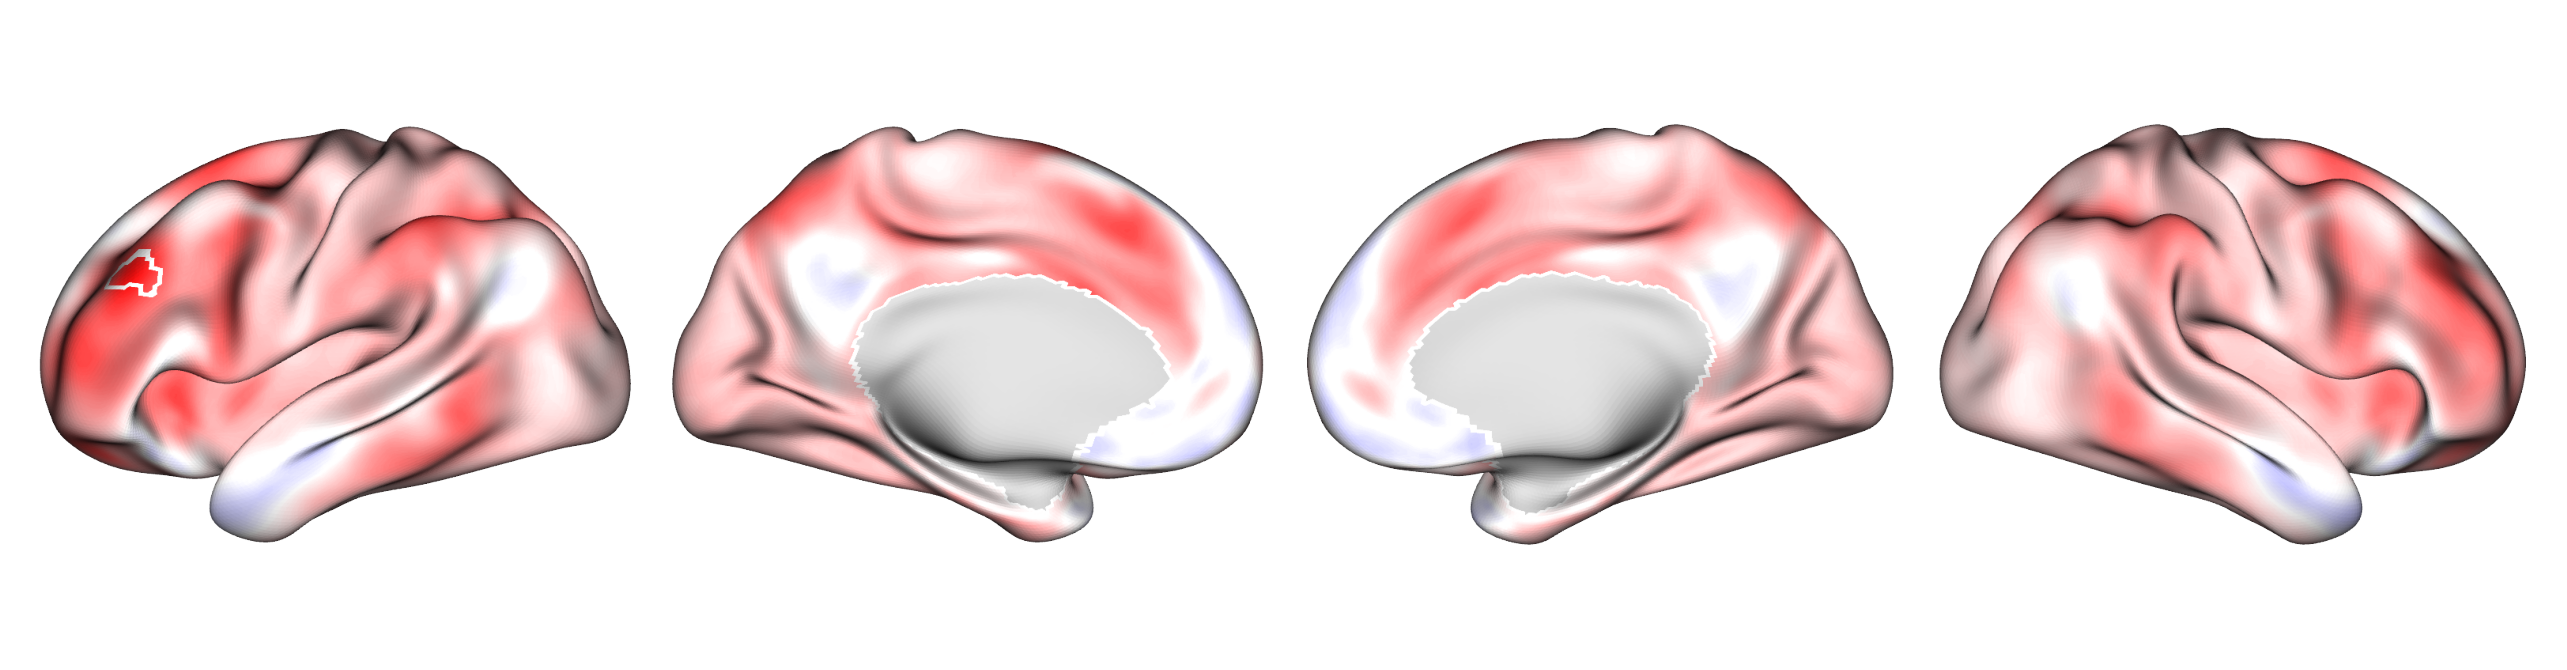

In [8]:
# convert to fsLR for plotting surface
cl_conn_fslr = transform.cifti_to_fsLR(cl_conn)
p = surfplot.Plot(surf_lh=plot.MESHES_FSLR['L'], surf_rh=plot.MESHES_FSLR['R'], 
                 layout='row', size = (1600, 400), zoom = 1.2, brightness=1, mirror_views=True,
                 )
vmin, vmax = (-1, 1)
p.add_layer(cl_conn_fslr, cmap='seismic_light', cbar=False, color_range=(vmin,vmax))
p.add_layer(cluster_mask_fslr, cmap='Greys_r', as_outline=True, cbar=False)
p.add_layer(~transform.FSLR_CORTEX, cmap='Greys_r', cbar=False, color_range=(0, 1.5))
p.build();

/data/group/cng/Projects/Amin/antidepressants_ale/venv/lib/python3.11/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


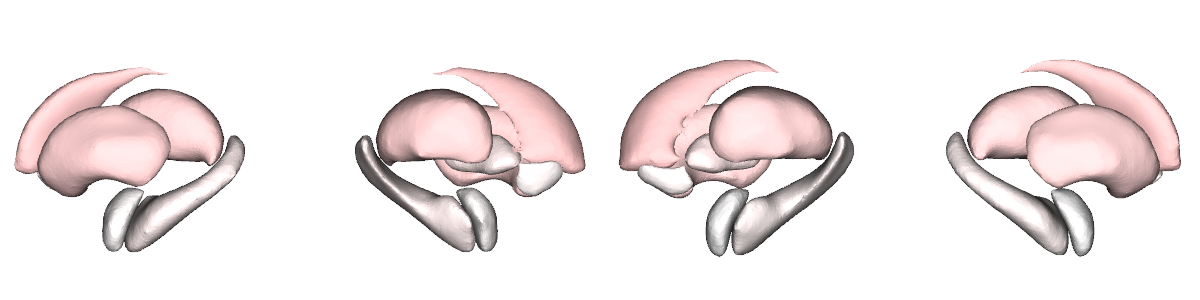

In [9]:
plot.plot_cifti_subcortical(cl_conn, color_range=(vmin, vmax), cmap='seismic_light')

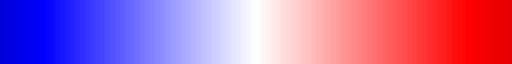

In [10]:
sns.color_palette('seismic_light', as_cmap=True)

Save to disk:

In [11]:
os.makedirs(os.path.join(io.RESULTS_DIR, 'rsfc', 'Contrast_increased_cFWE05'), exist_ok=True)
np.save(os.path.join(io.RESULTS_DIR, 'rsfc', 'Contrast_increased_cFWE05', 'cl_conn_mean_cifti.npy'), cl_conn)
np.save(os.path.join(io.RESULTS_DIR, 'rsfc', 'Contrast_increased_cFWE05', 'cl_conn_mean_fslr.npy'), cl_conn_fslr)